In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# pip install pickle5

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from glob import glob
import pickle5 as pickle
import numpy as np

ROOT_PATH = ""

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False, preprocess=False):
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs).astype(np.float64)

        outputs = None
    
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs).astype(np.float64)
        
    elif split=="test":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs).astype(np.float64)

        outputs = None
    
    if normalized:
        train_combined = np.concatenate([inputs, outputs], axis=1)
        x_mean = np.mean(train_combined[:, :, 0].reshape(-1))
        x_std = np.std(train_combined[:, :, 0].reshape(-1))
        x_norm = ((train_combined[:, :, 0].reshape(-1) - x_mean) / x_std).reshape(train_combined.shape[0], train_combined.shape[1], 1)

        y_mean = np.mean(train_combined[:, :, 1].reshape(-1))
        y_std = np.std(train_combined[:, :, 1].reshape(-1))
        y_norm = ((train_combined[:, :, 1].reshape(-1) - y_mean) / y_std).reshape(train_combined.shape[0], train_combined.shape[1], 1)

        normalized = np.concatenate([x_norm, y_norm], axis=2)
        
        return normalized[:, :50, :], normalized[:, 50:, :]

    if preprocess:
        preprocessed_inp = []
        preprocessed_out = []
        for i in range(inputs.shape[0]):
            temp_i, temp_o = preprocess_single(inputs[i], outputs[i])
            preprocessed_inp.append(temp_i)
            preprocessed_out.append(temp_o)

        preprocessed_inp = np.array(preprocessed_inp)
        preprocessed_out = np.array(preprocessed_out)
        
        return preprocessed_inp, preprocessed_out
    
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None, normalize=False, preprocess=False):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=normalize, preprocess=preprocess)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [4]:
# here inp and out are single-target
def preprocess_single(inp, out):
    x_i = inp[0][0]
    y_i = inp[0][1]
    
    prep_inp = np.concatenate([(inp[:, 0] - x_i).reshape(50, 1), (inp[:, 1] - y_i).reshape(50, 1)], axis=1)
    
    if out is None:
        return prep_inp, None

    prep_out = np.concatenate([(out[:, 0] - x_i).reshape(60, 1), (out[:, 1] - y_i).reshape(60, 1)], axis=1)
    
    return prep_inp, prep_out

In [5]:
import torch.nn as nn

In [6]:
class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
#             nn.Linear(64, 32),
            nn.Linear(64, 16)
#             nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 16)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 120),
            nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 120),
#             nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
#         print("------")
#         print(x.shape)
        x = x.reshape(-1, 60, 2)
        return x

In [7]:
pred = Pred()
opt = torch.optim.Adam(pred.parameters(), lr=0.0001)

In [8]:
batch_sz = 512  # batch size 
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
city = cities[0] 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split, normalize=False, preprocess=True)
train_loader = DataLoader(train_dataset, batch_size=batch_sz)

In [ ]:
# p_i, p_o = get_city_trajectories(city="palo-alto", split="train", normalized=False)
# train_combined = np.concatenate([p_i, p_o], axis=1)
# global_x_mean = np.mean(train_combined[:, :, 0].reshape(-1))
# global_x_std = np.std(train_combined[:, :, 0].reshape(-1))
# global_y_mean = np.mean(train_combined[:, :, 1].reshape(-1))
# global_y_std = np.std(train_combined[:, :, 1].reshape(-1))

In [ ]:
# global_x_mean

In [9]:
def train(pred):
    loss_lst = []
    for epoch in range(3000):
        total_loss = 0
        i = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch

#             print(inp.shape)
#             print(inp)
            preds = pred(inp)
#             print(preds.shape)
#             print(out.shape)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            i += len(inp) * 60 * 2
            
            total_loss += loss.item()
            
        loss_lst.append(total_loss / i)
        if epoch % 100 == 0:
            print('epoch {} loss: {}'.format(epoch, total_loss / i))
            
    plt.plot(loss_lst)
    
    return pred

In [10]:
import time

Starts training process
epoch 0 loss: 1862.2208721209236
epoch 100 loss: 34.046737346243084
epoch 200 loss: 29.450496090710562
epoch 300 loss: 27.58955319876675
epoch 400 loss: 26.496810150850933
epoch 500 loss: 25.75107238893705
epoch 600 loss: 25.19721310275287
epoch 700 loss: 24.74291609554018
epoch 800 loss: 24.367977733813024
epoch 900 loss: 24.040078601915113
epoch 1000 loss: 23.75190015501161
epoch 1100 loss: 23.49709030403921
epoch 1200 loss: 23.26363237454798
epoch 1300 loss: 23.054161354729295
epoch 1400 loss: 22.8636835706345
epoch 1500 loss: 22.68679345122708
epoch 1600 loss: 22.523499486163526
epoch 1700 loss: 22.36778692128865
epoch 1800 loss: 22.225219152783836
epoch 1900 loss: 22.092072523159885
epoch 2000 loss: 21.964041441409062
epoch 2100 loss: 21.849133515462476
epoch 2200 loss: 21.739230289558144
epoch 2300 loss: 21.632299508849623
epoch 2400 loss: 21.522851959801944
epoch 2500 loss: 21.41417052300382
epoch 2600 loss: 21.3138461317142
epoch 2700 loss: 21.2090776306

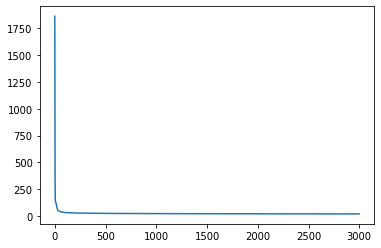

In [11]:
start = time.time()
print("Starts training process")
model = train(pred)
end = time.time()
print("Ends training process, total time - " + str(end - start))

Starts training process
epoch 0 loss: 20.933822164651975
epoch 100 loss: 20.847162338546674
epoch 200 loss: 20.747571896805265
epoch 300 loss: 20.665585656543385
epoch 400 loss: 20.58399496564162
epoch 500 loss: 20.507563354557384
epoch 600 loss: 20.436054203787453
epoch 700 loss: 20.36631137713754
epoch 800 loss: 20.28411344275682
epoch 900 loss: 20.202270703547356
epoch 1000 loss: 20.124937924378525
epoch 1100 loss: 20.054744264417135
epoch 1200 loss: 19.996455215600758
epoch 1300 loss: 19.944146799526894
epoch 1400 loss: 19.881684368947322
epoch 1500 loss: 19.825480105691977
epoch 1600 loss: 19.754845758697257
epoch 1700 loss: 19.696117298450552
epoch 1800 loss: 19.647498841155397
epoch 1900 loss: 19.593513005693108
epoch 2000 loss: 19.54080149825967
epoch 2100 loss: 19.48457757125478
epoch 2200 loss: 19.436036188495954
epoch 2300 loss: 19.388531967299645
epoch 2400 loss: 19.3435780432985
epoch 2500 loss: 19.29996136462672
epoch 2600 loss: 19.26066891901069
epoch 2700 loss: 19.21328

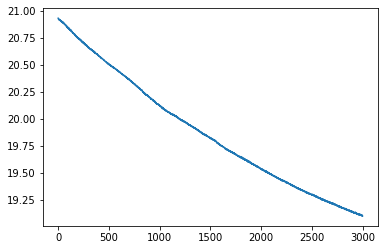

In [12]:
start = time.time()
print("Starts training process")
model2 = train(model)
end = time.time()
print("Ends training process, total time - " + str(end - start))

In [13]:
p_test_i, p_test_o = get_city_trajectories(city= city, split="test")

In [15]:
def predict(model, test_inp):
    x_i = test_inp[0][0]
    y_i = test_inp[0][1]
    
    pred = model(torch.tensor(preprocess_single(test_inp, None)[0]))[0]
    
    pred_x = pred[:, 0] + x_i
    pred_y = pred[:, 1] + y_i
    
    return pred_x, pred_y

In [16]:
# here inp and out are single-target
def preprocess_single(inp, out):
    x_i = inp[0][0]
    y_i = inp[0][1]
    
    prep_inp = np.concatenate([(inp[:, 0] - x_i).reshape(50, 1), (inp[:, 1] - y_i).reshape(50, 1)], axis=1)
    
    if out is None:
        return prep_inp, None

    prep_out = np.concatenate([(out[:, 0] - x_i).reshape(60, 1), (out[:, 1] - y_i).reshape(60, 1)], axis=1)
    
    return prep_inp, prep_out

In [19]:
palo_df = pd.DataFrame()
for i in range(len(p_test_i)):
    
#     predict = model_3(torch.tensor(normalize(p_test_i[i])))
    p_x, p_y = predict(model2, p_test_i[i])
    
    if i % 100 == 0:
        print("predicts for " + str(i) + " is done")
    temp_dict = {}
    for j in range(0, 120, 2):
        col_x = 'v' + str(j)
        col_y = 'v' + str(j+1)
        row = j // 2
#         temp_dict[col_x] = predict[0][row][0].item() * global_x_std + global_x_mean
#         temp_dict[col_y] = predict[0][row][1].item() * global_y_std + global_y_mean
        temp_dict[col_x] = p_x[row].item()
        temp_dict[col_y] = p_y[row].item()
    
    temp_idx_name = str(i) + "_" + city
    temp_final = pd.DataFrame(temp_dict, index=[temp_idx_name])
    palo_df = pd.concat([palo_df, temp_final])

predicts for 0 is done
predicts for 100 is done
predicts for 200 is done
predicts for 300 is done
predicts for 400 is done
predicts for 500 is done
predicts for 600 is done
predicts for 700 is done
predicts for 800 is done
predicts for 900 is done
predicts for 1000 is done
predicts for 1100 is done
predicts for 1200 is done
predicts for 1300 is done
predicts for 1400 is done
predicts for 1500 is done
predicts for 1600 is done
predicts for 1700 is done
predicts for 1800 is done
predicts for 1900 is done
predicts for 2000 is done
predicts for 2100 is done
predicts for 2200 is done
predicts for 2300 is done
predicts for 2400 is done
predicts for 2500 is done
predicts for 2600 is done
predicts for 2700 is done
predicts for 2800 is done
predicts for 2900 is done
predicts for 3000 is done
predicts for 3100 is done
predicts for 3200 is done
predicts for 3300 is done
predicts for 3400 is done
predicts for 3500 is done
predicts for 3600 is done
predicts for 3700 is done
predicts for 3800 is don

In [21]:
palo_df.reset_index(level=0).rename(columns={"index": "ID"}).to_csv("model5_{}.csv".format(city), index=False)